In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.spatial.distance import cosine, euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import cv2
from PIL import Image
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE
from subject.braintreebank import BrainTreebankSubject
import pandas as pd
import math
import json

SUBJECT_TRIAL_TO_MOVIE = {
    (1,0): 'fantastic-mr-fox.mp4',
    (1,1): 'the-martian.mp4',
    (1,2): 'thor-ragnarok.mp4',
    (2,0): 'venom.mp4',
    (2,1): 'spider-man-3-homecoming.mp4',
    (2,2): 'guardians-of-the-galaxy.mp4',
    (2,3): 'guardians-of-the-galaxy-2.mp4',
    (2,4): 'avengers-infinity-war.mp4',
    (2,5): 'black-panther.mp4',
    (2,6): 'aquaman.mp4',
    (3,0): 'cars-2.mp4',
    (3,1): 'lotr-1.mp4',
    (3,2): 'lotr-2.mp4',
    (4,0): 'shrek-the-third.mp4',
    (4,1): 'megamind.mp4',
    (4,2): 'incredibles.mp4',
    (5,0): 'fantastic-mr-fox.mp4',
    (6,0): 'megamind.mp4',
    (6,1): 'toy-story.mp4',
    (6,2): 'coraline.mp4',
    (7,0): 'cars-2.mp4',
    (7,1): 'megamind.mp4',
    (8,0): 'sesame-street-episode-3990.mp4',
    (9,0): 'ant-man.mp4',
    (10,0): 'cars-2.mp4',
    (10,1): 'spider-man-far-from-home.mp4',
}

CLIP_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/"
MOVIES_DIR = "/om2/data/public/braintreebank_movies/"
SCENE_ANNOTATION_FILE = '/om2/user/zaho/braintreebank/braintreebank/scene_annotations.json'

In [2]:
def get_movie_data(movie):
    clip_features_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_clip_features.npy'))
    timestamps_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_timestamps.npy'))
    movie_path = os.path.join(MOVIES_DIR, movie)

    clip_features = np.load(clip_features_path)  # shape: (num_samples, feature_dim)
    timestamps = np.load(timestamps_path)
    return clip_features, timestamps, movie_path

In [6]:
movie = 'ant-man.mp4'
clip_features, timestamps, movie_path = get_movie_data(movie)
clip_features

array([[-0.013054, -0.023   , -0.0494  , ...,  0.0675  , -0.03183 ,
        -0.0256  ],
       [-0.013054, -0.023   , -0.0494  , ...,  0.0675  , -0.03183 ,
        -0.0256  ],
       [-0.013054, -0.023   , -0.0494  , ...,  0.0675  , -0.03183 ,
        -0.0256  ],
       ...,
       [-0.013054, -0.023   , -0.0494  , ...,  0.0675  , -0.03183 ,
        -0.0256  ],
       [-0.013054, -0.023   , -0.0494  , ...,  0.0675  , -0.03183 ,
        -0.0256  ],
       [-0.013054, -0.023   , -0.0494  , ...,  0.0675  , -0.03183 ,
        -0.0256  ]], dtype=float16)

In [12]:
import cv2
from PIL import Image
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE
from subject.braintreebank import BrainTreebankSubject
import pandas as pd

def extract_frame_at_time(video_path, timestamp):
    """
    Extract a frame from video at a specific timestamp.
    
    Args:
        video_path (str): Path to the video file
        timestamp (float): Timestamp in seconds
    Returns:
        PIL.Image: The extracted frame as PIL Image
    """
    cap = cv2.VideoCapture(video_path)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int(timestamp * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Warning: Could not extract frame at timestamp {timestamp}")
        return None
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    return pil_image

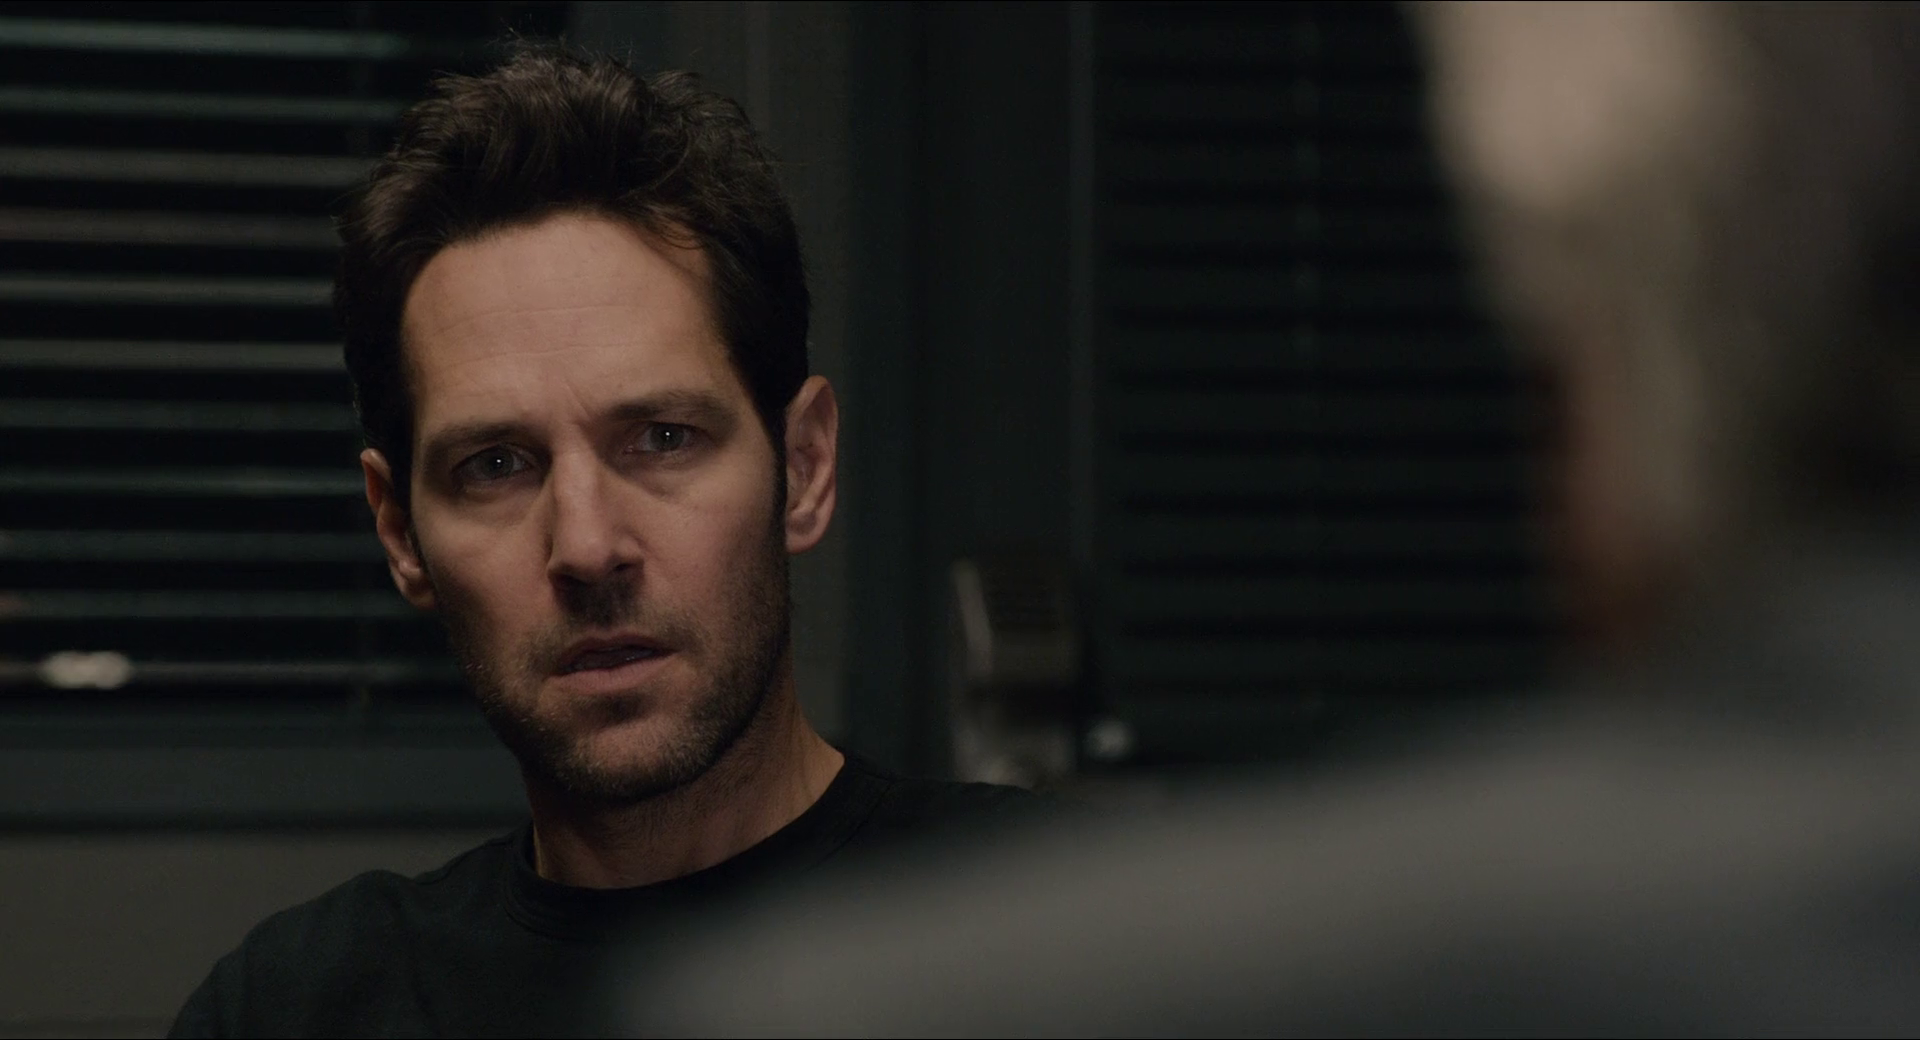

In [27]:
extract_frame_at_time(movie_path, 2108)

In [15]:
# Load and print the first few lines of the scene annotation JSON file
with open(SCENE_ANNOTATION_FILE, 'r') as f:
    scene_data = json.load(f)

movie_keys = [key for key in scene_data[0].keys() if f'{movie.replace(".mp4", "")}' in key]
movie_keys


['movie:annotations:v3:ant-man:jkdewit',
 'movie:annotations:v3:ant-man:vsub851',
 'movie:all-annotations:v3:ant-man',
 'movie:annotations:v3:ant-man:USERNAME']

In [46]:
print(movie_keys[3])
scene_data[0][movie_keys[3]]

movie:all-annotations:v3:cars-2


{'{"startTime":2433,"endTime":2433,"label":"#"}': '2433.0',
 '{"startTime":2432,"endTime":2432,"label":"#"}': '2432.0',
 '{"startTime":2431,"endTime":2431,"label":"#"}': '2431.0',
 '{"startTime":2430,"endTime":2430,"label":"#"}': '2430.0',
 '{"startTime":2429,"endTime":2429,"label":"#"}': '2429.0',
 '{"startTime":2428,"endTime":2428,"label":"#"}': '2428.0',
 '{"startTime":2427,"endTime":2427,"label":"#"}': '2427.0',
 '{"startTime":2426,"endTime":2426,"label":"#"}': '2426.0',
 '{"startTime":2425,"endTime":2425,"label":"#"}': '2425.0',
 '{"startTime":2424,"endTime":2424,"label":"#"}': '2424.0',
 '{"startTime":2423,"endTime":2423,"label":"#"}': '2423.0',
 '{"startTime":2422,"endTime":2422,"label":"#"}': '2422.0',
 '{"startTime":2421,"endTime":2421,"label":"#"}': '2421.0',
 '{"startTime":2420,"endTime":2420,"label":"#"}': '2420.0',
 '{"startTime":2419,"endTime":2419,"label":"#"}': '2419.0',
 '{"startTime":2418,"endTime":2418,"label":"#"}': '2418.0',
 '{"startTime":2417,"endTime":2417,"labe

In [36]:
scene_dict_1 = {}
for entry in scene_data[0][movie_keys[0]]:
    time = float(scene_data[0][movie_keys[0]][entry])
    entry_dict = json.loads(entry)
    label = entry_dict['label']

    if time not in scene_dict_1:
        scene_dict_1[time] = [label]
    else:
        scene_dict_1[time].append(label)

scene_dict_1

{3093.0: ['#'],
 3092.0: ['#'],
 3091.0: ['#'],
 3090.0: ['storage room'],
 3089.0: ['storage room'],
 3088.0: ['storage room'],
 3087.0: ['storage room'],
 3086.0: ['storage room'],
 3085.0: ['storage room'],
 3084.0: ['#'],
 3083.0: ['#'],
 3082.0: ['#'],
 3081.0: ['#'],
 3080.0: ['basement'],
 3079.0: ['basement'],
 3078.0: ['basement'],
 3077.0: ['basement'],
 3076.0: ['basement'],
 3075.0: ['basement'],
 3074.0: ['basement'],
 3073.0: ['basement'],
 3072.0: ['basement'],
 3071.0: ['basement'],
 3070.0: ['basement'],
 3069.0: ['basement'],
 3068.0: ['basement'],
 3067.0: [''],
 3066.0: ['#'],
 3065.0: ['#'],
 3064.0: ['#'],
 3063.0: ['#'],
 3062.0: ['#'],
 3061.0: ['#'],
 3060.0: ['#'],
 3059.0: ['#'],
 3058.0: ['#'],
 3057.0: ['#'],
 3056.0: ['#'],
 3055.0: ['#'],
 3054.0: ['#'],
 3053.0: ['#'],
 3052.0: ['#'],
 3051.0: ['#'],
 3050.0: ['#'],
 3049.0: ['#'],
 3048.0: ['#'],
 3047.0: ['#'],
 3046.0: ['#'],
 3045.0: ['#'],
 3044.0: ['#'],
 3043.0: ['#'],
 3042.0: ['#'],
 3041.0: ['#

In [57]:
def get_scene_dict(key):
    scene_dict_1 = {}
    for entry in scene_data[0][key]:
        time = float(scene_data[0][key][entry])
        entry_dict = json.loads(entry)
        label = entry_dict['label']

        if label == '' or '@' in label:
            label = '#'

        if time not in scene_dict_1:
            scene_dict_1[time] = [label]
        else:
            if label == '#':
                continue
            scene_dict_1[time].append(label)

    return scene_dict_1

def get_scenes(movie):
    with open(SCENE_ANNOTATION_FILE, 'r') as f:
        scene_data = json.load(f)
    movie_keys = [key for key in scene_data[0].keys() if f'{movie.replace(".mp4", "")}' in key and 'all-annotations' in key]
    return get_scene_dict(movie_keys[0])

In [59]:
get_scenes(movie)

{3093.0: ['#'],
 3092.0: ['#'],
 3091.0: ['#'],
 3090.0: ['storage room'],
 3089.0: ['storage room'],
 3088.0: ['storage room'],
 3087.0: ['storage room'],
 3086.0: ['storage room'],
 3085.0: ['storage room'],
 3084.0: ['#'],
 3083.0: ['#'],
 3082.0: ['#'],
 3081.0: ['#'],
 3080.0: ['basement'],
 3079.0: ['basement'],
 3078.0: ['basement'],
 3077.0: ['basement'],
 3076.0: ['basement'],
 3075.0: ['basement'],
 3074.0: ['basement'],
 3073.0: ['basement'],
 3072.0: ['basement'],
 3071.0: ['basement'],
 3070.0: ['basement'],
 3069.0: ['basement'],
 3068.0: ['basement'],
 3067.0: ['#'],
 3066.0: ['#'],
 3065.0: ['#'],
 3064.0: ['#'],
 3063.0: ['#'],
 3062.0: ['#'],
 3061.0: ['#'],
 3060.0: ['#'],
 3059.0: ['#'],
 3058.0: ['#'],
 3057.0: ['#'],
 3056.0: ['#'],
 3055.0: ['#'],
 3054.0: ['#'],
 3053.0: ['#'],
 3052.0: ['#'],
 3051.0: ['#'],
 3050.0: ['#'],
 3049.0: ['#'],
 3048.0: ['#'],
 3047.0: ['#'],
 3046.0: ['#'],
 3045.0: ['#'],
 3044.0: ['#'],
 3043.0: ['#'],
 3042.0: ['#'],
 3041.0: ['

In [60]:
def get_scene_changes(scene_dict):
    times = []
    scene_dict[0.0] = ['#']
    for i in range(1, len(scene_dict.keys())):
        if not any(label in scene_dict[i-1] for label in scene_dict[i]):
            times.append(i)
    return times

get_scene_changes(get_scenes(movie))

[1,
 2,
 43,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 66,
 67,
 69,
 72,
 105,
 111,
 112,
 122,
 123,
 134,
 135,
 145,
 182,
 183,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 211,
 212,
 231,
 232,
 233,
 236,
 242,
 263,
 284,
 291,
 293,
 294,
 347,
 348,
 417,
 429,
 433,
 434,
 455,
 488,
 489,
 491,
 499,
 500,
 501,
 502,
 503,
 506,
 511,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 526,
 529,
 530,
 532,
 549,
 550,
 551,
 552,
 554,
 559,
 560,
 567,
 602,
 667,
 668,
 672,
 696,
 733,
 771,
 773,
 784,
 785,
 786,
 789,
 795,
 797,
 799,
 856,
 857,
 858,
 860,
 866,
 890,
 955,
 964,
 1005,
 1017,
 1146,
 1157,
 1158,
 1246,
 1247,
 1248,
 1251,
 1292,
 1302,
 1305,
 1317,
 1318,
 1320,
 1321,
 1322,
 1326,
 1327,
 1328,
 1344,
 1345,
 1349,
 1378,
 1382,
 1413,
 1462,
 1472,
 1497,
 1522,
 1527,
 1529,
 1531,
 1532,
 1533,
 1547,
 1549,
 1563,
 1565,
 1566,
 1568,
 1569,
 1571,
 1574,
 1577,
 1578,
 1580,
 1581,
 1582,
 1583,
 1586,
 1587,
 1